# Import

In [1]:
import pandas
import sklearn
import evaluation
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
GPU_fix = "MemoryFix" # Choose "Disable", "MemoryFix" or "None"

if GPU_fix == "Disable":
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
elif GPU_fix == "MemoryFix":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


# Read training data

In [216]:
# https://www.kaggle.com/sionek/ugbc-gs
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv.zip', index_col='id')
variables = ['LifeTime',
             'dira',
             'FlightDistance',
             'FlightDistanceError',
             'IP',
             'IPSig',
             'VertexChi2',
             'pt',
             'DOCAone',
             'DOCAtwo',
             'DOCAthree',
             'IP_p0p2',
             'IP_p1p2',
             'isolationa',
             'isolationb',
             'isolationc',
             'isolationd',
             'isolatione',
             'isolationf',
             'iso',
             'CDF1',
             'CDF2',
             'CDF3',
             'ISO_SumBDT',
             'p0_IsoBDT',
             'p1_IsoBDT',
             'p2_IsoBDT',
             'p0_track_Chi2Dof',
             'p1_track_Chi2Dof',
             'p2_track_Chi2Dof',
             'p0_IP',
             'p1_IP',
             'p2_IP',
             'p0_IPSig',
             'p1_IPSig',
             'p2_IPSig',
             'p0_pt',
             'p1_pt',
             'p2_pt',
             'p0_p',
             'p1_p',
             'p2_p',
             'p0_eta',
             'p1_eta',
             'p2_eta',
             'SPDhits',
             ]
train_df = data[variables]

In [225]:
# https://www.kaggle.com/sionek/ugbc-gs
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv.zip', index_col='id')
#--------------- feature engineering -------------- #
def add_features(df):
    # features used by the others on Kaggle
    df['NEW_FD_SUMP']=df['FlightDistance']/(df['p0_p']+df['p1_p']+df['p2_p'])
    df['NEW5_lt']=df['LifeTime']*(df['p0_IP']+df['p1_IP']+df['p2_IP'])/3
    df['p_track_Chi2Dof_MAX'] = df.loc[:, ['p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof']].max(axis=1)
    #df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError'] # modified to:
    df['flight_dist_sig2'] = (df['FlightDistance']/df['FlightDistanceError'])**2
    # features from phunter
    df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    df['NEW_IP_dira'] = df['IP']*df['dira']
    df['p0p2_ip_ratio']=df['IP']/df['IP_p0p2']
    df['p1p2_ip_ratio']=df['IP']/df['IP_p1p2']
    df['DCA_MAX'] = df.loc[:, ['DOCAone', 'DOCAtwo', 'DOCAthree']].max(axis=1)
    df['iso_bdt_min'] = df.loc[:, ['p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT']].min(axis=1)
    df['iso_min'] = df.loc[:, ['isolationa', 'isolationb', 'isolationc','isolationd', 'isolatione', 'isolationf']].min(axis=1)
    # My:
    # new combined features just to minimize their number;
    # their physical sense doesn't matter
    df['NEW_iso_abc'] = df['isolationa']*df['isolationb']*df['isolationc']
    df['NEW_iso_def'] = df['isolationd']*df['isolatione']*df['isolationf']
    df['NEW_pN_IP'] = df['p0_IP']+df['p1_IP']+df['p2_IP']
    df['NEW_pN_p']  = df['p0_p']+df['p1_p']+df['p2_p']
    df['NEW_IP_pNpN'] = df['IP_p0p2']*df['IP_p1p2']
    df['NEW_pN_IPSig'] = df['p0_IPSig']+df['p1_IPSig']+df['p2_IPSig']
    #My:
    # "super" feature changing the result from 0.988641 to 0.991099
    df['NEW_FD_LT']=df['FlightDistance']/df['LifeTime']
    return df

print("Add features")
train_df = add_features(data)

print("Eliminate features")
filter_out = ['id', 'min_ANNmuon', 'production', 'mass', 'signal',
              'SPDhits','CDF1', 'CDF2', 'CDF3',
              'p0_pt', 'p1_pt', 'p2_pt',
              'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta',
              'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',
              'p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree']

Add features
Eliminate features


In [4]:
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv.zip')
filter1 = ['production', 'mass', 'signal', 'weight','min_ANNmuon']
data1  = data[list(f for f in data.columns if f not in filter1)]

In [5]:
data1.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits'],
      dtype='object')

In [15]:
import featuretools as ft

es = ft.EntitySet(id='data')
es.entity_from_dataframe(entity_id = 'df', dataframe = data1, index = 'id')
print(es)

Entityset: data
  Entities:
    df [Rows: 67553, Columns: 47]
  Relationships:
    No relationships


c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\featuretools\__init__.py:60: FutureWarning: The next non-bugfix release of Featuretools will not support Python 3.6
  FutureWarning


In [16]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
target_entity = 'df', 
max_depth = 1, 
verbose = 1, 
n_jobs = 3,
trans_primitives = ['add_numeric'])

Built 1081 features
EntitySet scattered to 3 workers in 3 seconds                                                                          
Elapsed: 00:08 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [18]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    feature_matrix,
    data['signal'],
    test_size=0.2,
    random_state=0)
x_train.shape, x_val.shape

((54042, 1081), (13511, 1081))

In [20]:
scaler = StandardScaler()
scaler.fit(x_train.fillna(0))

StandardScaler()

In [23]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(scaler.transform(x_train.fillna(0)), y_train)
sel_.get_support()

array([ True,  True, False, ...,  True,  True,  True])

In [26]:
selected_feat =x_train.columns[(sel_.get_support())]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))
removed_feats = x_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats
x_train_selected = sel_.transform(x_train.fillna(0))
x_val_selected = sel_.transform(x_val.fillna(0))
x_train_selected.shape, x_val_selected.shape

total features: 1081
selected features: 461
features with coefficients shrank to zero: 596


((54042, 461), (13511, 461))

In [19]:
len(feature_names)

1081

In [224]:
train_df = feature_matrix[list(f for f in feature_matrix.columns if f not in filter1)]

In [226]:
#modified
variables_mod = list(f for f in data.columns if f not in filter_out)
print(len(variables_mod))

28


In [227]:

train_df = data[variables_mod]


In [228]:
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
val = train_df[~msk]

In [229]:
print('validation samples:',len(val))
print('train samples:',len(train))

validation samples: 13555
train samples: 53998


# Baseline training

In [230]:
#Create training arrays
x_train = train
y_train = data['signal'][msk].to_numpy()
y_train = np.expand_dims(y_train,1)
x_val = val
y_val = data['signal'][~msk].to_numpy()
y_val = np.expand_dims(y_val,1)

In [64]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv.zip', index_col='id')
check_agreement = add_features(check_agreement)
check_agreement1 = check_agreement[variables_mod].to_numpy()


In [65]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv.zip', index_col='id')
check_correlation = add_features(check_correlation)
check_correlation1 = check_correlation[variables_mod].to_numpy()


In [83]:
def my_loss(check_agreement,check_correlation):
    def my_loss_in(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy()
        check_correlation1 = check_correlation[variables_mod].to_numpy()
        check_agreement1 = check_agreement[variables_mod].to_numpy()
        #agreement_probs = model1m(check_agreement1).numpy()
        #ks = evaluation.compute_ks(
           # agreement_probs[check_agreement['signal'].values == 0],
           # agreement_probs[check_agreement['signal'].values == 1],
           # check_agreement[check_agreement['signal'] == 0]['weight'].values,
           # check_agreement[check_agreement['signal'] == 1]['weight'].values)
        #correlation_probs = model1m(check_correlation1).numpy()
        correlation_probs = model1m(check_correlation1).numpy(lambda x: tf.py_function(parse_tfrecord(x, class_table, size), [x], (tf.uint8, tf.float32)))
        cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
        return bce(y_true, y_pred) + 10*exp(cvm)
    return my_loss_in



In [134]:
import tensorflow as tf

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    #self.inputs = tf.keras.layers.InputLayer(len(variables_mod))
    self.bnorm1 = tf.keras.layers.BatchNormalization()
    self.bnorm2 = tf.keras.layers.BatchNormalization()
    self.bnorm3 = tf.keras.layers.BatchNormalization()
    self.bnorm4 = tf.keras.layers.BatchNormalization()
    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)
    self.dense1 = tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    self.dense2 = tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    self.dense3 = tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    self.dense4 = tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.2))
    self.dense5 = tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)

  def call(self, inputs):
    #x = self.inputs(inputs)
    x = self.bnorm1(inputs)
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.bnorm2(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    x = self.bnorm3(x)
    x = self.dropout3(x)
    x = self.dense3(x)
    x = self.bnorm4(x)
    x = self.dropout4(x)
    x = self.dense4(x)
    bce = tf.keras.losses.BinaryCrossentropy()
    agreement_probs = self.predict(check_agreement1)
    ks = evaluation.compute_ks(
        agreement_probs[check_agreement['signal'].values == 0],
        agreement_probs[check_agreement['signal'].values == 1],
        check_agreement[check_agreement['signal'] == 0]['weight'].values,
        check_agreement[check_agreement['signal'] == 1]['weight'].values)
    correlation_probs = self.predict(check_correlation1)
    cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
    loss = bce(y_true, y_pred) + exp(ks) + 10*exp(cvm)
    self.add_loss(self)
    return self.dense5(x)

model = MyModel()

model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
#model.build(input_shape = (len(variables_mod),1))
#model.summary()


Подключение LR Scheduler

In [45]:
def scheduler(epoch, lr):
    if epoch % 300 != 0:
        return lr
    else:
        return lr/5

Создание тюнера

In [ ]:
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=len(variables_mod)))
    model.add(tf.keras.layers.BatchNormalization())
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=10,
                                            max_value=200,
                                            step=10),
                               activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='BinaryCrossentropy',
        metrics=['accuracy'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner1',
    project_name='ttt')

In [ ]:
tuner.search(x_train, y_train,
             epochs=100,
             validation_data=(x_val, y_val), batch_size = 128)

In [ ]:
tuner.results_summary()

In [ ]:
model_tuned = tuner.get_best_models(num_models=1)[0]

In [28]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(len(selected_feat)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),  
  tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [221]:
model1m = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(len(variables_mod)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),  
  tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
])
model1m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.layers import PReLU
model = Sequential()
model.add(Input(shape=len(variables_mod)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(75))
model.add(PReLU())

model.add(Dropout(0.13))
model.add(Dense(60))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(45))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(30))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [100]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [28]:
history_32 = model1m.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_val,y_val))
model1m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history_64 = model1m.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_data = (x_val,y_val))
model1m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history_128 = model1m.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data = (x_val,y_val))
model1m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history_256 = model1m.fit(x_train, y_train, epochs = 100, batch_size = 256, validation_data = (x_val,y_val))

Epoch 1/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.4168 - accuracy: 0.8131 - val_loss: 0.3427 - val_accuracy: 0.8537
Epoch 2/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3974 - accuracy: 0.8240 - val_loss: 0.3406 - val_accuracy: 0.8526
Epoch 3/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3937 - accuracy: 0.8270 - val_loss: 0.3392 - val_accuracy: 0.8568
Epoch 4/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3904 - accuracy: 0.8280 - val_loss: 0.3385 - val_accuracy: 0.8565
Epoch 5/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3873 - accuracy: 0.8304 - val_loss: 0.3393 - val_accuracy: 0.8589
Epoch 6/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3867 - accuracy: 0.8310 - val_loss: 0.3413 - val_accuracy: 0.8576
Epoch 7/100
1695/1695 [==============================] - 7s 4ms/step - loss: 0.3859 - accuracy: 0.8317 - val_loss: 0.3360 - val_ac

848/848 [==============================] - 4s 5ms/step - loss: 0.3583 - accuracy: 0.8426 - val_loss: 0.3268 - val_accuracy: 0.8600
Epoch 14/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3574 - accuracy: 0.8439 - val_loss: 0.3276 - val_accuracy: 0.8604
Epoch 15/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3597 - accuracy: 0.8435 - val_loss: 0.3289 - val_accuracy: 0.8602
Epoch 16/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3594 - accuracy: 0.8444 - val_loss: 0.3295 - val_accuracy: 0.8613
Epoch 17/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3593 - accuracy: 0.8445 - val_loss: 0.3258 - val_accuracy: 0.8613
Epoch 18/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3573 - accuracy: 0.8451 - val_loss: 0.3260 - val_accuracy: 0.8629
Epoch 19/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3598 - accuracy: 0.8431 - val_loss: 0.3271 - val_accuracy: 0.8622
Epoch

Epoch 70/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3584 - accuracy: 0.8450 - val_loss: 0.3285 - val_accuracy: 0.8625
Epoch 71/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3582 - accuracy: 0.8431 - val_loss: 0.3320 - val_accuracy: 0.8604
Epoch 72/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3600 - accuracy: 0.8433 - val_loss: 0.3268 - val_accuracy: 0.8601
Epoch 73/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3590 - accuracy: 0.8441 - val_loss: 0.3285 - val_accuracy: 0.8623
Epoch 74/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3565 - accuracy: 0.8458 - val_loss: 0.3272 - val_accuracy: 0.8607
Epoch 75/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3583 - accuracy: 0.8440 - val_loss: 0.3259 - val_accuracy: 0.8622
Epoch 76/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3573 - accuracy: 0.8451 - val_loss: 0.3270 - val_accuracy:

Epoch 27/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3526 - accuracy: 0.8480 - val_loss: 0.3229 - val_accuracy: 0.8628
Epoch 28/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3550 - accuracy: 0.8454 - val_loss: 0.3264 - val_accuracy: 0.8636
Epoch 29/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3534 - accuracy: 0.8468 - val_loss: 0.3246 - val_accuracy: 0.8630
Epoch 30/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3540 - accuracy: 0.8473 - val_loss: 0.3244 - val_accuracy: 0.8638
Epoch 31/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3532 - accuracy: 0.8471 - val_loss: 0.3254 - val_accuracy: 0.8632
Epoch 32/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3529 - accuracy: 0.8479 - val_loss: 0.3235 - val_accuracy: 0.8630
Epoch 33/100
424/424 [==============================] - 2s 5ms/step - loss: 0.3542 - accuracy: 0.8470 - val_loss: 0.3251 - val_accuracy:

Epoch 84/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3533 - accuracy: 0.8467 - val_loss: 0.3233 - val_accuracy: 0.8640
Epoch 85/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.8466 - val_loss: 0.3254 - val_accuracy: 0.8630
Epoch 86/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3533 - accuracy: 0.8469 - val_loss: 0.3255 - val_accuracy: 0.8604
Epoch 87/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3516 - accuracy: 0.8473 - val_loss: 0.3238 - val_accuracy: 0.8623
Epoch 88/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3543 - accuracy: 0.8457 - val_loss: 0.3252 - val_accuracy: 0.8626
Epoch 89/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3525 - accuracy: 0.8488 - val_loss: 0.3251 - val_accuracy: 0.8620
Epoch 90/100
424/424 [==============================] - 2s 4ms/step - loss: 0.3523 - accuracy: 0.8474 - val_loss: 0.3255 - val_accuracy:

Epoch 41/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3502 - accuracy: 0.8481 - val_loss: 0.3228 - val_accuracy: 0.8632
Epoch 42/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3506 - accuracy: 0.8478 - val_loss: 0.3224 - val_accuracy: 0.8643
Epoch 43/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3514 - accuracy: 0.8470 - val_loss: 0.3236 - val_accuracy: 0.8640
Epoch 44/100
212/212 [==============================] - 1s 5ms/step - loss: 0.3495 - accuracy: 0.8469 - val_loss: 0.3249 - val_accuracy: 0.8620
Epoch 45/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3492 - accuracy: 0.8483 - val_loss: 0.3227 - val_accuracy: 0.8620
Epoch 46/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3511 - accuracy: 0.8478 - val_loss: 0.3236 - val_accuracy: 0.8627
Epoch 47/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3524 - accuracy: 0.8471 - val_loss: 0.3241 - val_accuracy:

Epoch 98/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3503 - accuracy: 0.8484 - val_loss: 0.3234 - val_accuracy: 0.8639
Epoch 99/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3503 - accuracy: 0.8477 - val_loss: 0.3239 - val_accuracy: 0.8631
Epoch 100/100
212/212 [==============================] - 1s 4ms/step - loss: 0.3509 - accuracy: 0.8465 - val_loss: 0.3228 - val_accuracy: 0.8626


In [38]:
history_64 = model1m.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_data = (x_val,y_val))

Epoch 1/100
848/848 [==============================] - 4s 4ms/step - loss: 0.4110 - accuracy: 0.8166 - val_loss: 0.3482 - val_accuracy: 0.8514
Epoch 2/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3888 - accuracy: 0.8292 - val_loss: 0.3429 - val_accuracy: 0.8520
Epoch 3/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3844 - accuracy: 0.8310 - val_loss: 0.3518 - val_accuracy: 0.8516
Epoch 4/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3823 - accuracy: 0.8329 - val_loss: 0.3416 - val_accuracy: 0.8536
Epoch 5/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3813 - accuracy: 0.8336 - val_loss: 0.3374 - val_accuracy: 0.8583
Epoch 6/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3809 - accuracy: 0.8343 - val_loss: 0.3312 - val_accuracy: 0.8592
Epoch 7/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3773 - accuracy: 0.8342 - val_loss: 0.3414 - val_accuracy: 0.8559

Epoch 58/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3636 - accuracy: 0.8403 - val_loss: 0.3287 - val_accuracy: 0.8610
Epoch 59/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3646 - accuracy: 0.8424 - val_loss: 0.3336 - val_accuracy: 0.8625
Epoch 60/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3635 - accuracy: 0.8420 - val_loss: 0.3315 - val_accuracy: 0.8598
Epoch 61/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3639 - accuracy: 0.8409 - val_loss: 0.3284 - val_accuracy: 0.8619
Epoch 62/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3641 - accuracy: 0.8417 - val_loss: 0.3288 - val_accuracy: 0.8634
Epoch 63/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3651 - accuracy: 0.8408 - val_loss: 0.3277 - val_accuracy: 0.8605
Epoch 64/100
848/848 [==============================] - 4s 4ms/step - loss: 0.3630 - accuracy: 0.8411 - val_loss: 0.3274 - val_accuracy:

In [29]:

history = model1.fit(x_train_selected, y_train, epochs = 200, batch_size = 128, validation_data = (x_val_selected,y_val))

Epoch 1/200
423/423 [==============================] - 2s 5ms/step - loss: 0.3619 - accuracy: 0.8436 - val_loss: 0.2960 - val_accuracy: 0.8758
Epoch 2/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3216 - accuracy: 0.8652 - val_loss: 0.2875 - val_accuracy: 0.8797
Epoch 3/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3151 - accuracy: 0.8688 - val_loss: 0.2823 - val_accuracy: 0.8800
Epoch 4/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3083 - accuracy: 0.8718 - val_loss: 0.2795 - val_accuracy: 0.8856
Epoch 5/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3079 - accuracy: 0.8726 - val_loss: 0.2774 - val_accuracy: 0.8837
Epoch 6/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3030 - accuracy: 0.8734 - val_loss: 0.2753 - val_accuracy: 0.8854
Epoch 7/200
423/423 [==============================] - 2s 4ms/step - loss: 0.3043 - accuracy: 0.8732 - val_loss: 0.2725 - val_accuracy: 0.8883

Epoch 58/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2751 - accuracy: 0.8870 - val_loss: 0.2609 - val_accuracy: 0.8910
Epoch 59/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2754 - accuracy: 0.8865 - val_loss: 0.2602 - val_accuracy: 0.8896
Epoch 60/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2745 - accuracy: 0.8866 - val_loss: 0.2597 - val_accuracy: 0.8918
Epoch 61/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2764 - accuracy: 0.8851 - val_loss: 0.2619 - val_accuracy: 0.8901
Epoch 62/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2757 - accuracy: 0.8870 - val_loss: 0.2599 - val_accuracy: 0.8902
Epoch 63/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2754 - accuracy: 0.8850 - val_loss: 0.2599 - val_accuracy: 0.8927
Epoch 64/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2737 - accuracy: 0.8870 - val_loss: 0.2610 - val_accuracy:

Epoch 115/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2672 - accuracy: 0.8891 - val_loss: 0.2589 - val_accuracy: 0.8920
Epoch 116/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2691 - accuracy: 0.8895 - val_loss: 0.2599 - val_accuracy: 0.8913
Epoch 117/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2695 - accuracy: 0.8891 - val_loss: 0.2574 - val_accuracy: 0.8929
Epoch 118/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2673 - accuracy: 0.8905 - val_loss: 0.2579 - val_accuracy: 0.8916
Epoch 119/200
423/423 [==============================] - 2s 5ms/step - loss: 0.2708 - accuracy: 0.8861 - val_loss: 0.2567 - val_accuracy: 0.8922
Epoch 120/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2694 - accuracy: 0.8878 - val_loss: 0.2559 - val_accuracy: 0.8933
Epoch 121/200
423/423 [==============================] - 2s 5ms/step - loss: 0.2670 - accuracy: 0.8905 - val_loss: 0.2578 - val_ac

In [231]:
historym = model1m.fit(x_train, y_train, epochs = 200, batch_size = 128, validation_data = (x_val,y_val))

Epoch 1/200
422/422 [==============================] - 2s 5ms/step - loss: 0.4125 - accuracy: 0.8170 - val_loss: 0.3507 - val_accuracy: 0.8541
Epoch 2/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3862 - accuracy: 0.8298 - val_loss: 0.3458 - val_accuracy: 0.8532
Epoch 3/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3795 - accuracy: 0.8339 - val_loss: 0.3432 - val_accuracy: 0.8530
Epoch 4/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3781 - accuracy: 0.8341 - val_loss: 0.3465 - val_accuracy: 0.8518
Epoch 5/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3748 - accuracy: 0.8356 - val_loss: 0.3420 - val_accuracy: 0.8539
Epoch 6/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3739 - accuracy: 0.8370 - val_loss: 0.3433 - val_accuracy: 0.8508
Epoch 7/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3726 - accuracy: 0.8373 - val_loss: 0.3424 - val_accuracy: 0.8544

Epoch 58/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3598 - accuracy: 0.8453 - val_loss: 0.3350 - val_accuracy: 0.8571
Epoch 59/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3576 - accuracy: 0.8438 - val_loss: 0.3347 - val_accuracy: 0.8552
Epoch 60/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3580 - accuracy: 0.8448 - val_loss: 0.3348 - val_accuracy: 0.8554
Epoch 61/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3573 - accuracy: 0.8449 - val_loss: 0.3377 - val_accuracy: 0.8575
Epoch 62/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3571 - accuracy: 0.8442 - val_loss: 0.3348 - val_accuracy: 0.8571
Epoch 63/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3572 - accuracy: 0.8451 - val_loss: 0.3364 - val_accuracy: 0.8547
Epoch 64/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3578 - accuracy: 0.8451 - val_loss: 0.3347 - val_accuracy:

422/422 [==============================] - 2s 4ms/step - loss: 0.3542 - accuracy: 0.8453 - val_loss: 0.3335 - val_accuracy: 0.8567
Epoch 171/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.8465 - val_loss: 0.3345 - val_accuracy: 0.8550
Epoch 172/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3540 - accuracy: 0.8462 - val_loss: 0.3335 - val_accuracy: 0.8560
Epoch 173/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3541 - accuracy: 0.8468 - val_loss: 0.3310 - val_accuracy: 0.8581
Epoch 174/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.8467 - val_loss: 0.3357 - val_accuracy: 0.8558
Epoch 175/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.8456 - val_loss: 0.3350 - val_accuracy: 0.8561
Epoch 176/200
422/422 [==============================] - 2s 4ms/step - loss: 0.3534 - accuracy: 0.8460 - val_loss: 0.3341 - val_accuracy: 0.8558

In [79]:
tf.executing_eagerly()

True

In [47]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model1m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history2 = model1m.fit(x_train, y_train, epochs = 1000, batch_size = 128, validation_data = (x_val,y_val), callbacks = [callback])

Epoch 1/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.4500 - accuracy: 0.7963 - val_loss: 0.3528 - val_accuracy: 0.8464
Epoch 2/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.4074 - accuracy: 0.8174 - val_loss: 0.3468 - val_accuracy: 0.8483
Epoch 3/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3959 - accuracy: 0.8229 - val_loss: 0.3450 - val_accuracy: 0.8485
Epoch 4/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3964 - accuracy: 0.8242 - val_loss: 0.3428 - val_accuracy: 0.8511
Epoch 5/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3865 - accuracy: 0.8319 - val_loss: 0.3408 - val_accuracy: 0.8528
Epoch 6/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3895 - accuracy: 0.8281 - val_loss: 0.3423 - val_accuracy: 0.8512
Epoch 7/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3876 - accuracy: 0.8288 - val_loss: 0.3403 - val_accuracy:

424/424 [==============================] - 2s 5ms/step - loss: 0.3586 - accuracy: 0.8436 - val_loss: 0.3222 - val_accuracy: 0.8619
Epoch 114/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3605 - accuracy: 0.8432 - val_loss: 0.3248 - val_accuracy: 0.8629
Epoch 115/1000
424/424 [==============================] - 2s 6ms/step - loss: 0.3582 - accuracy: 0.8442 - val_loss: 0.3240 - val_accuracy: 0.8628
Epoch 116/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3596 - accuracy: 0.8433 - val_loss: 0.3233 - val_accuracy: 0.8635
Epoch 117/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3601 - accuracy: 0.8435 - val_loss: 0.3243 - val_accuracy: 0.8624
Epoch 118/1000
424/424 [==============================] - 3s 7ms/step - loss: 0.3590 - accuracy: 0.8439 - val_loss: 0.3235 - val_accuracy: 0.8641
Epoch 119/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3595 - accuracy: 0.8432 - val_loss: 0.3236 - val_accuracy: 

424/424 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.8479 - val_loss: 0.3234 - val_accuracy: 0.8626
Epoch 226/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3555 - accuracy: 0.8454 - val_loss: 0.3238 - val_accuracy: 0.8616
Epoch 227/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3556 - accuracy: 0.8450 - val_loss: 0.3232 - val_accuracy: 0.8628
Epoch 228/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3551 - accuracy: 0.8463 - val_loss: 0.3244 - val_accuracy: 0.8621
Epoch 229/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3567 - accuracy: 0.8444 - val_loss: 0.3243 - val_accuracy: 0.8615
Epoch 230/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3556 - accuracy: 0.8459 - val_loss: 0.3246 - val_accuracy: 0.8634
Epoch 231/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3561 - accuracy: 0.8457 - val_loss: 0.3237 - val_accuracy: 

424/424 [==============================] - 2s 5ms/step - loss: 0.3543 - accuracy: 0.8464 - val_loss: 0.3228 - val_accuracy: 0.8622
Epoch 338/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3536 - accuracy: 0.8465 - val_loss: 0.3234 - val_accuracy: 0.8613
Epoch 339/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3548 - accuracy: 0.8471 - val_loss: 0.3225 - val_accuracy: 0.8616
Epoch 340/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3536 - accuracy: 0.8464 - val_loss: 0.3228 - val_accuracy: 0.8622
Epoch 341/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.8471 - val_loss: 0.3231 - val_accuracy: 0.8630
Epoch 342/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3532 - accuracy: 0.8472 - val_loss: 0.3231 - val_accuracy: 0.8619
Epoch 343/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3545 - accuracy: 0.8458 - val_loss: 0.3237 - val_accuracy: 

424/424 [==============================] - 2s 5ms/step - loss: 0.3527 - accuracy: 0.8479 - val_loss: 0.3227 - val_accuracy: 0.8625
Epoch 450/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3540 - accuracy: 0.8458 - val_loss: 0.3236 - val_accuracy: 0.8631
Epoch 451/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3547 - accuracy: 0.8460 - val_loss: 0.3239 - val_accuracy: 0.8627
Epoch 452/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3505 - accuracy: 0.8482 - val_loss: 0.3230 - val_accuracy: 0.8627
Epoch 453/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3529 - accuracy: 0.8470 - val_loss: 0.3232 - val_accuracy: 0.8626
Epoch 454/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3537 - accuracy: 0.8478 - val_loss: 0.3230 - val_accuracy: 0.8629
Epoch 455/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.8464 - val_loss: 0.3229 - val_accuracy: 

424/424 [==============================] - 2s 4ms/step - loss: 0.3523 - accuracy: 0.8460 - val_loss: 0.3235 - val_accuracy: 0.8631
Epoch 562/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3503 - accuracy: 0.8471 - val_loss: 0.3224 - val_accuracy: 0.8637
Epoch 563/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3519 - accuracy: 0.8467 - val_loss: 0.3233 - val_accuracy: 0.8631
Epoch 564/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3534 - accuracy: 0.8476 - val_loss: 0.3236 - val_accuracy: 0.8636
Epoch 565/1000
424/424 [==============================] - 3s 7ms/step - loss: 0.3522 - accuracy: 0.8470 - val_loss: 0.3235 - val_accuracy: 0.8629
Epoch 566/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3526 - accuracy: 0.8465 - val_loss: 0.3229 - val_accuracy: 0.8639
Epoch 567/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.8459 - val_loss: 0.3229 - val_accuracy: 

424/424 [==============================] - 2s 5ms/step - loss: 0.3526 - accuracy: 0.8477 - val_loss: 0.3234 - val_accuracy: 0.8629
Epoch 674/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3528 - accuracy: 0.8471 - val_loss: 0.3235 - val_accuracy: 0.8628
Epoch 675/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3503 - accuracy: 0.8478 - val_loss: 0.3230 - val_accuracy: 0.8633
Epoch 676/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3529 - accuracy: 0.8464 - val_loss: 0.3228 - val_accuracy: 0.8630
Epoch 677/1000
424/424 [==============================] - 2s 5ms/step - loss: 0.3531 - accuracy: 0.8478 - val_loss: 0.3234 - val_accuracy: 0.8636
Epoch 678/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3537 - accuracy: 0.8472 - val_loss: 0.3230 - val_accuracy: 0.8632
Epoch 679/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3509 - accuracy: 0.8481 - val_loss: 0.3233 - val_accuracy: 

424/424 [==============================] - 2s 4ms/step - loss: 0.3518 - accuracy: 0.8492 - val_loss: 0.3230 - val_accuracy: 0.8631
Epoch 786/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3537 - accuracy: 0.8466 - val_loss: 0.3239 - val_accuracy: 0.8627
Epoch 787/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3521 - accuracy: 0.8496 - val_loss: 0.3233 - val_accuracy: 0.8638
Epoch 788/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3520 - accuracy: 0.8468 - val_loss: 0.3229 - val_accuracy: 0.8636
Epoch 789/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3489 - accuracy: 0.8489 - val_loss: 0.3231 - val_accuracy: 0.8637
Epoch 790/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3500 - accuracy: 0.8480 - val_loss: 0.3228 - val_accuracy: 0.8646
Epoch 791/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3509 - accuracy: 0.8485 - val_loss: 0.3227 - val_accuracy: 

424/424 [==============================] - 2s 4ms/step - loss: 0.3526 - accuracy: 0.8469 - val_loss: 0.3236 - val_accuracy: 0.8634
Epoch 898/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3507 - accuracy: 0.8478 - val_loss: 0.3233 - val_accuracy: 0.8633
Epoch 899/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3525 - accuracy: 0.8472 - val_loss: 0.3226 - val_accuracy: 0.8634
Epoch 900/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.8484 - val_loss: 0.3231 - val_accuracy: 0.8627
Epoch 901/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3528 - accuracy: 0.8467 - val_loss: 0.3231 - val_accuracy: 0.8632
Epoch 902/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3522 - accuracy: 0.8466 - val_loss: 0.3230 - val_accuracy: 0.8635
Epoch 903/1000
424/424 [==============================] - 2s 4ms/step - loss: 0.3519 - accuracy: 0.8478 - val_loss: 0.3231 - val_accuracy: 

In [142]:

x_train.shape
check_agreement1.shape

(331147, 28)

In [ ]:
model1.optimizer.lr.numpy()

In [23]:
model1.save('my_model.h5')

In [17]:
model1.save_weights('./models/my_model/x.h5')

In [ ]:
model1.save_weights('./models/my_model/m_bnorm')
model.save_weights('./models/imported_model/i_bnorm')

# Check agreement test

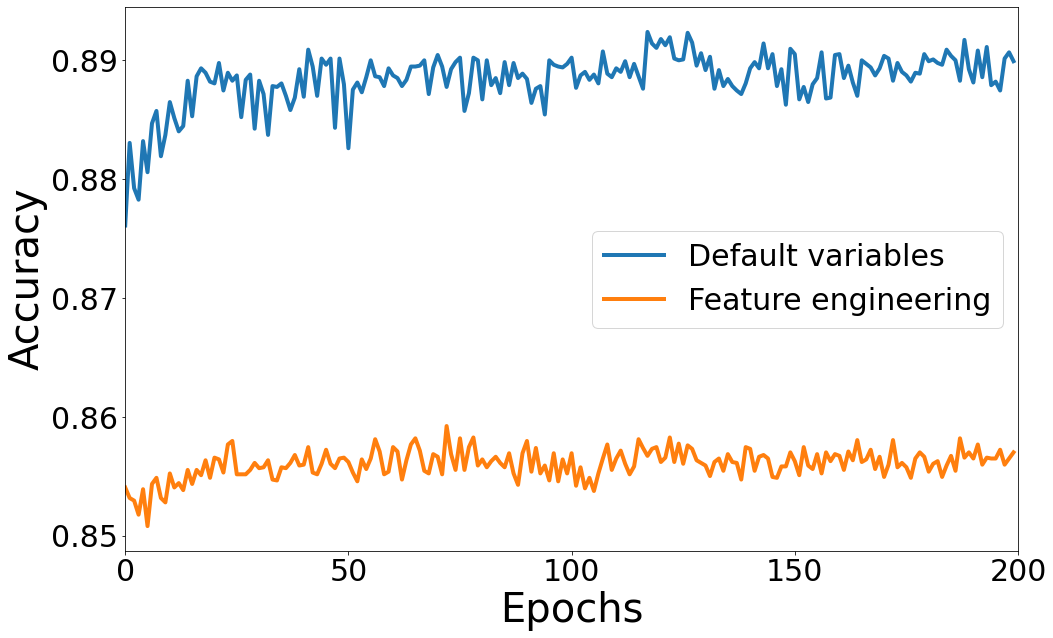

<Figure size 432x288 with 0 Axes>

In [232]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': '150',
         'axes.titlesize':'40',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(16,10))

plt.xlabel('Epochs',size=40)
plt.ylabel("Accuracy",size=40)
val = plt.plot(history.epoch, history.history['val_'+'accuracy'],
             label='Default variables', linewidth = 4)
plt.plot(historym.epoch, historym.history['val_'+'accuracy'],
             label='Feature engineering', linewidth = 4)

plt.legend(prop={'size':30})
plt.xticks(fontsize = 30)
plt.xticks(np.arange(0, max(history.epoch)+10, 50.0))
plt.yticks(fontsize = 30)
#plt.yticks(np.arange(romin(history.history['val_'+'accuracy']), max(history.history['val_'+'accuracy']), 2))
plt.xlim([0,max(history.epoch)+1])
plt.show()
plt.savefig('test.png', bbox_inches='tight')

In [ ]:
model_tuned.predict(train_df)

In [30]:
data_agr = pandas.read_csv(folder + 'check_agreement.csv.zip')
data_agr1 = data_agr[list(f for f in data_agr.columns if f not in filter1)]

In [36]:
check_agreement = data_agr
es_agr = ft.EntitySet(id='data_agr')
es_agr.entity_from_dataframe(entity_id = 'df_agr', dataframe = data_agr1, index = 'id')

Entityset: data_agr
  Entities:
    df_agr [Rows: 331147, Columns: 47]
  Relationships:
    No relationships

In [37]:

feature_matrix_agr, feature_names_agr = ft.dfs(entityset=es_agr, 
target_entity = 'df_agr', 
max_depth = 1, 
verbose = 1, 
n_jobs = 3,
trans_primitives = ['add_numeric'])
check_agreement1 = feature_matrix_agr

Built 1081 features
EntitySet scattered to 3 workers in 4 seconds                                                                          
Elapsed: 00:40 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [ ]:
check_agreement1 = sel_.transform(check_agreement1.fillna(0))



In [42]:
check_agreement1.shape

(331147, 461)

In [44]:
#check_agreement = pandas.read_csv(folder + 'check_agreement.csv.zip', index_col='id')
#check_agreement = add_features(check_agreement)

#check_agreement1 = check_agreement[variables_mod].to_numpy()
agreement_probs = model1.predict(check_agreement1)
print(agreement_probs)
ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)

[[0.23265803]
 [0.00177309]
 [0.39068684]
 ...
 [0.96447545]
 [0.988817  ]
 [0.9879995 ]]
KS metric 0.27842199273103607 False


# Check correlation test

In [55]:
data_cor = pandas.read_csv(folder + 'check_correlation.csv.zip')
data_cor1 = data_cor[list(f for f in data_cor.columns if f not in filter1)]
check_correlation = data_cor
es_cor = ft.EntitySet(id='data_cor')
es_cor.entity_from_dataframe(entity_id = 'df_cor', dataframe = data_cor1, index = 'id')

Entityset: data_cor
  Entities:
    df_cor [Rows: 5514, Columns: 47]
  Relationships:
    No relationships

In [56]:
feature_matrix_cor, feature_names_cor = ft.dfs(entityset=es_cor, 
target_entity = 'df_cor', 
max_depth = 1, 
verbose = 1, 
n_jobs = 3,
trans_primitives = ['add_numeric'])
check_correlation1 = feature_matrix_cor

Built 1081 features
EntitySet scattered to 3 workers in 3 seconds                                                                          
Elapsed: 00:02 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [57]:
check_correlation1 = sel_.transform(check_correlation1.fillna(0))

In [59]:
#check_correlation = pandas.read_csv(folder + 'check_correlation.csv.zip', index_col='id')
#check_correlation = add_features(check_correlation)
#check_correlation1 = check_correlation[variables_mod].to_numpy()
correlation_probs = model1.predict(check_correlation1).squeeze()

cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric', cvm, cvm < 0.002)

CvM metric 0.0010599120449313502 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [108]:
train_eval = data[data['min_ANNmuon'] > 0.4]
train_probs = model1m.predict(train_eval[variables_mod].to_numpy()).squeeze()
AUC = sklearn.metrics.roc_auc_score(train_eval['signal'], train_probs)
print('AUC', AUC)

ValueError: in user code:

    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\emile\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_21 is incompatible with the layer: expected axis 1 of input shape to have value 2500 but received input with shape [None, 10]


# Predict test, create file for kaggle

In [ ]:
result = pandas.DataFrame({'id': test.index})
result['prediction'] = model.predict(test[variables].to_numpy()).squeeze()

In [ ]:
result.to_csv('submission.csv', index=False, sep=',')

In [ ]:
!ls -l submission.csv

In [ ]:
result.to_csv?